In [1]:
import numpy as np

from lava.proc.lif.process import LIF, LearningLIF
from lava.proc.io.source import RingBuffer as SpikeIn
from lava.proc.dense.process import LearningDense, Dense 
from lava.magma.core.learning.learning_rule import LoihiLearningRule
from lava.proc.monitor.process import Monitor
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

# Learning rule coefficient
A_plus = -2
A_minus = 2

learning_rate = "2 ^ -6"

# Trace decay constants
x1_tau = 10
y1_tau = 10

# Eligibility trace decay constant
tag_tau = "2 ^ -1" 

# error signal decay constant
y2_tau = 10 
# surrogate gradient of membrane potential u, decay constant
y3_tau = 2 ** 32-1 

# Impulses
x1_impulse = 1
y1_impulse = 1

# Zero impulse value for reward. 
y2_impulse = 0
y3_impulse = 0

# Epoch length
t_epoch = 2

# String learning rule for dt : eligibility trace represented as t
dt = f"u0 * y3 * x1 - u0 * {tag_tau} * t"

# String learning rule for dw
dw = f"{learning_rate} * u0 * y2 * t"

# Create custom LearningRule
SuperSpike = LoihiLearningRule(dw=dw,
                           dt=dt,
                         x1_impulse=x1_impulse,
                         x1_tau=x1_tau,
                         y1_impulse=y1_impulse,
                         y1_tau=y1_tau,
                         y2_impulse=y2_impulse,
                         y2_tau=y2_tau,
                         y3_impulse=y3_impulse,
                         y3_tau=y3_tau,
                         t_epoch=t_epoch)


# Set this tag to "fixed_pt" or "floating_pt" to choose the corresponding models.
SELECT_TAG = "floating_pt"

# LIF parameters : Only supports floating_pt for now. 
if SELECT_TAG == "floating_pt":
    du = 0.3
    dv = 0.6

vth = 1

# Number of pre-synaptic neurons per layer
num_neurons_pre = 1
shape_lif_pre = (num_neurons_pre, )
shape_conn_pre = (num_neurons_pre, num_neurons_pre)

# Number of post-synaptic neurons per layer
num_neurons_post = 1
shape_lif_post = (num_neurons_post, )
shape_conn_post = (num_neurons_post, num_neurons_post)

# Connection parameters

# SpikePattern -> LIF connection weight : PRE-synaptic
wgt_inp_pre = np.eye(num_neurons_pre) * 1

# SpikePattern -> LIF connection weight : POST-synaptic
wgt_inp_post = np.eye(num_neurons_post) * 250

# Error SpikePattern -> LIF connection weight : ERROR
wgt_inp_reward = np.eye(num_neurons_post) * 1

# LIF -> LIF connection initial weight (learning-enabled)
wgt_plast_conn = np.full(shape_conn_post, 1)
    
# time duration
n_steps = 500

# Spike times
spike_prob = 0.03

# Create random spike rasters
np.random.seed(1523)
spike_raster_pre = np.zeros((num_neurons_pre, n_steps))
np.place(spike_raster_pre, np.random.rand(num_neurons_pre, n_steps) < spike_prob, 1)

# Number of simulation time steps
num_steps = 500
time = list(range(1, num_steps + 1))

spike_raster_pre = np.resize(spike_raster_pre, (num_neurons_pre, num_steps))

# Create error spike signal
error_spike_signal = np.zeros((num_neurons_post, num_steps)) 
for index in range(num_steps):
    if index % 300 == 0:
        error_spike_signal[0][index] = 1

# Create input devices
pattern_pre = SpikeIn(data=spike_raster_pre.astype(int))
# pattern_post = SpikeIn(data=spike_raster_post.astype(int))

# Create error signal input device
reward_pattern_post = SpikeIn(data=error_spike_signal.astype(float))

# Create input connectivity
conn_inp_pre = Dense(weights=wgt_inp_pre)
# conn_inp_post = Dense(weights=wgt_inp_post)
conn_inp_reward = Dense(weights=wgt_inp_reward)

# Create pre-synaptic neurons
lif_pre = LIF(u=0,
              v=0,
              du=du,
              dv=du,
              bias_mant=0,
              bias_exp=0,
              vth=vth,
              shape=shape_lif_pre,
              name='lif_pre')

# Create plastic connection
plast_conn = LearningDense(weights=wgt_plast_conn,
                   learning_rule=SuperSpike,
                   name='plastic_dense')

# Create post-synaptic neuron
lif_post = LearningLIF(u=0,
               v=0,
               du=du,
               dv=du,
               bias_mant=0,
               bias_exp=0,
               vth=vth,
               shape=shape_lif_post,
               name='lif_post')

# Connect network
pattern_pre.s_out.connect(conn_inp_pre.s_in)
conn_inp_pre.a_out.connect(lif_pre.a_in)

# pattern_post.s_out.connect(conn_inp_post.s_in)
# conn_inp_post.a_out.connect(lif_post.a_in)

# Reward ports
reward_pattern_post.s_out.connect(conn_inp_reward.s_in)
conn_inp_reward.a_out.connect(lif_post.a_third_factor_in)

lif_pre.s_out.connect(plast_conn.s_in)
plast_conn.a_out.connect(lif_post.a_in)

# Connect back-propagating action potential (BAP)
lif_post.s_out_bap.connect(plast_conn.s_in_bap)

# Connect reward trace callback (y2, y3)
lif_post.s_out_y2.connect(plast_conn.s_in_y2)
lif_post.s_out_y3.connect(plast_conn.s_in_y3)

# Create monitors
mon_pre_trace = Monitor()
mon_post_trace = Monitor()
mon_membrane_potential = Monitor()
mon_error_trace = Monitor()
mon_membrane_trace = Monitor()
mon_pre_spikes = Monitor()
mon_post_spikes = Monitor()
mon_weight = Monitor()
mon_tag = Monitor()
mon_y2 = Monitor()
mon_y3 = Monitor()
mon_s_error_out = Monitor()


# Connect monitors
mon_pre_trace.probe(plast_conn.x1, num_steps)
mon_post_trace.probe(lif_post.s_out_bap, num_steps)
mon_s_error_out.probe(lif_post.s_error_out, num_steps)

mon_membrane_potential.probe(lif_post.v, num_steps)
mon_error_trace.probe(lif_post.s_out_y2, num_steps)
mon_membrane_trace.probe(lif_post.s_out_y3, num_steps)

mon_pre_spikes.probe(lif_pre.s_out, num_steps)
mon_post_spikes.probe(lif_post.s_out, num_steps)
mon_weight.probe(plast_conn.weights, num_steps)
mon_tag.probe(plast_conn.tag_1, num_steps)

mon_y2.probe(plast_conn.y2, num_steps)
mon_y3.probe(plast_conn.y3, num_steps)

# Running
pattern_pre.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi2SimCfg(select_tag=SELECT_TAG))


In [2]:
# Get data from monitors
pre_trace = mon_pre_trace.get_data()['plastic_dense']['x1']
post_trace = mon_post_trace.get_data()['lif_post']['s_out_bap']
s_error_out_ = mon_s_error_out.get_data()['lif_post']['s_error_out']

membrane_potential = mon_membrane_potential.get_data()['lif_post']['v']
error_trace = mon_error_trace.get_data()['lif_post']['s_out_y2']
membrane_trace = mon_membrane_trace.get_data()['lif_post']['s_out_y3']

pre_spikes = mon_pre_spikes.get_data()['lif_pre']['s_out']
post_spikes = mon_post_spikes.get_data()['lif_post']['s_out']
weights = mon_weight.get_data()['plastic_dense']['weights'][:, :, 0]
tag = mon_tag.get_data()['plastic_dense']['tag_1'][:, :, 0]

y2_ = mon_y2.get_data()['plastic_dense']['y2']
y3_ = mon_y3.get_data()['plastic_dense']['y3']

# Stopping
pattern_pre.stop()

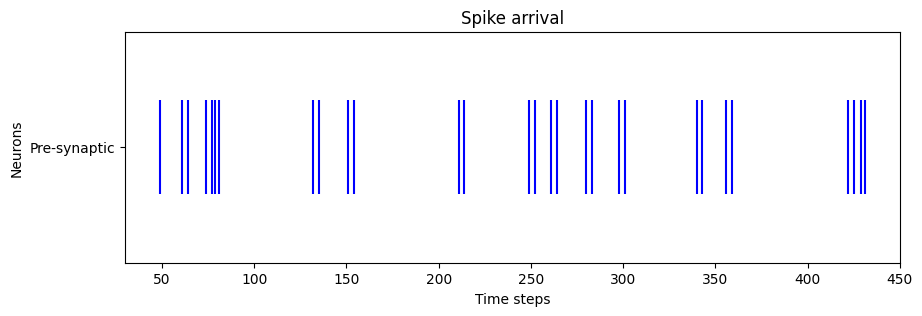

In [3]:
import matplotlib.pyplot as plt

# Plotting pre- and post- spike arrival
def plot_spikes(spikes, legend, colors):
    offsets = list(range(1, len(spikes) + 1))
    
    plt.figure(figsize=(10, 3))
    
    spikes_plot = plt.eventplot(positions=spikes, 
                                lineoffsets=offsets,
                                linelength=0.9,
                                colors=colors)
    
    plt.title("Spike arrival")
    plt.xlabel("Time steps")
    plt.ylabel("Neurons")
    plt.yticks(ticks=offsets, labels=legend)
    
    plt.show()

# Plot spikes
plot_spikes(spikes=[np.where(pre_spikes[:, 0])[0]], 
            legend=['Pre-synaptic'], 
            colors=['blue'])

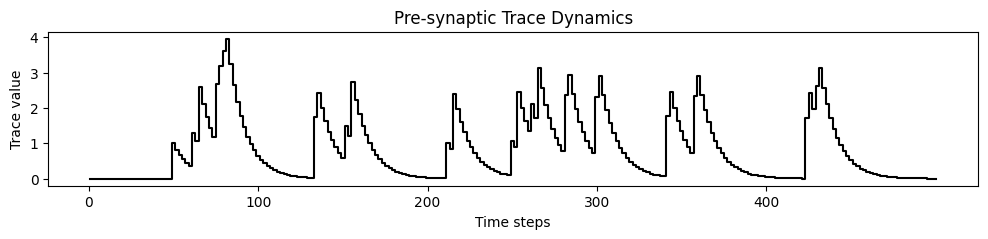

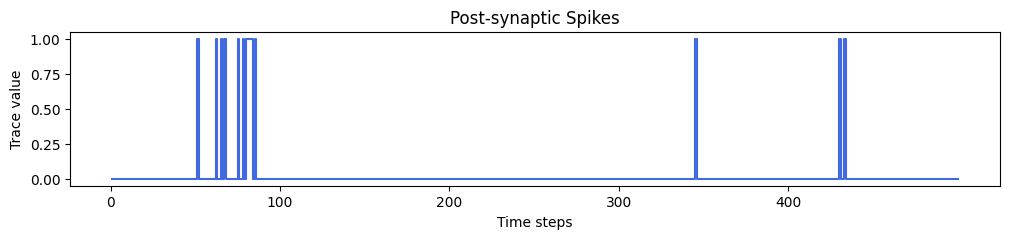

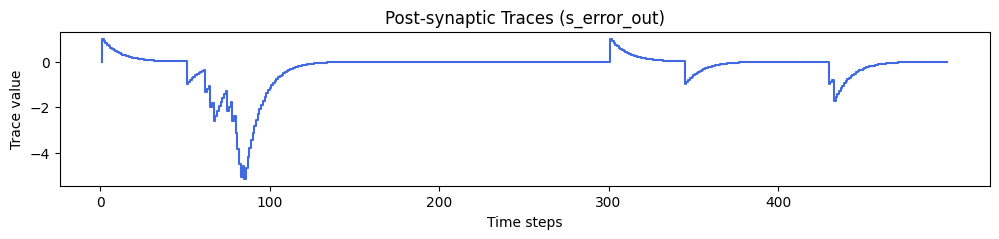

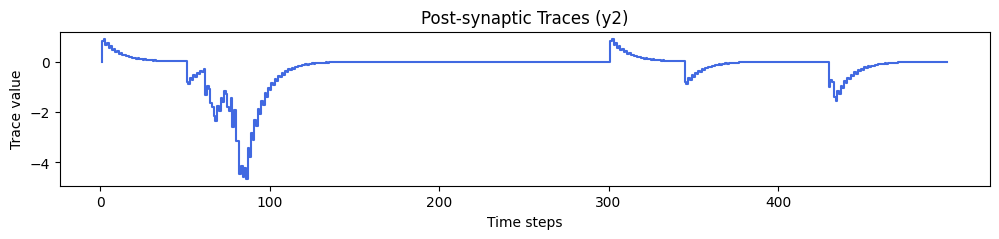

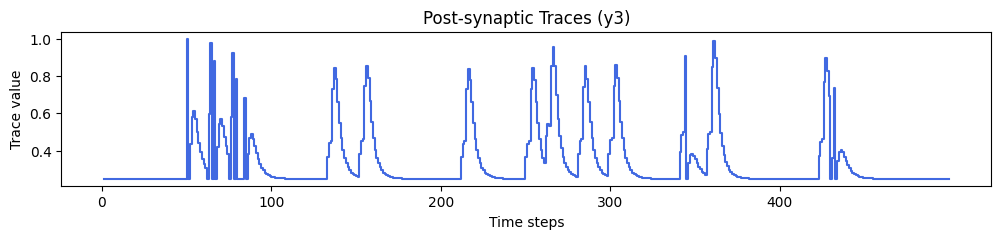

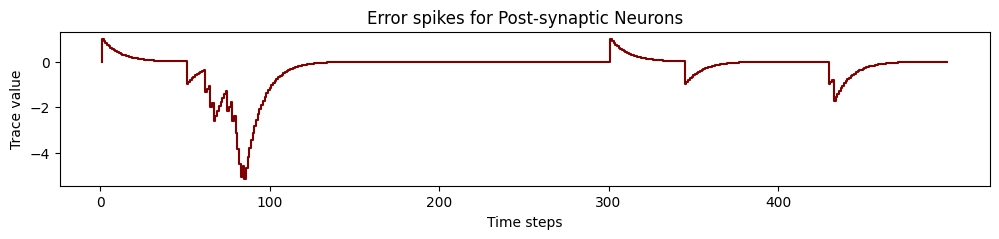

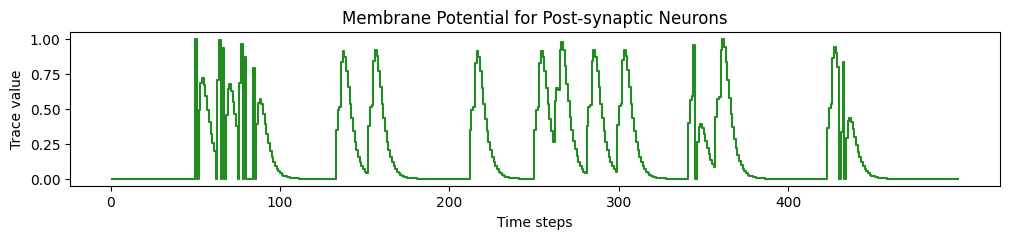

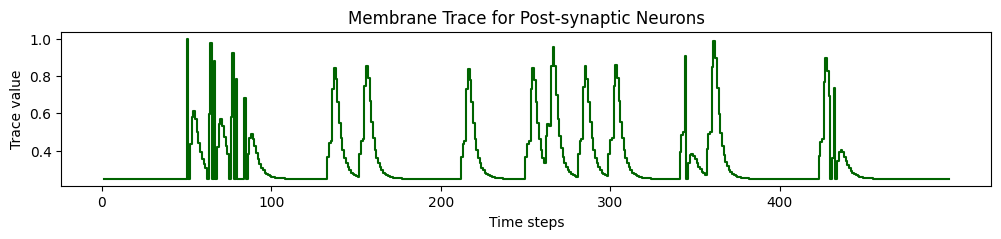

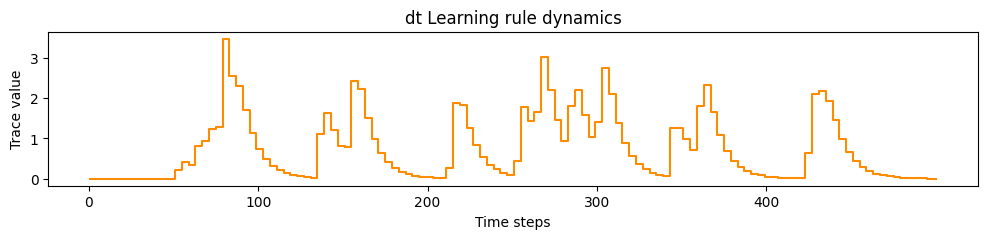

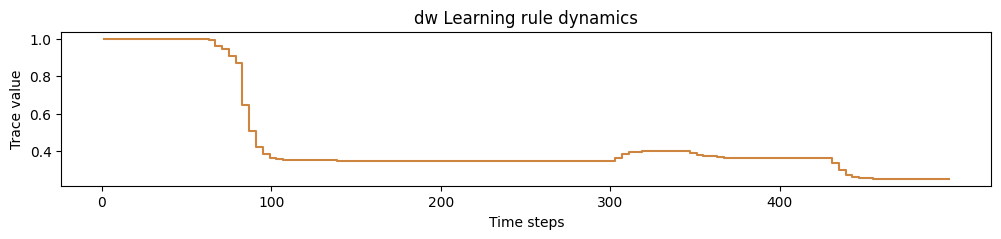

In [4]:
# Plotting trace dynamics
    
def plot_time_series(time, time_series, ylabel, title, figsize, color):
    plt.figure(figsize=figsize)
    
    plt.step(time, time_series, color=color)
    
    
    plt.title(title)
    plt.xlabel("Time steps")
    plt.ylabel(ylabel)
    plt.xticks(np.arange(0, num_steps, 100))
    
    plt.show()

    # Plotting pre trace dynamics
plot_time_series(time=time, time_series=pre_trace, ylabel="Trace value", title="Pre-synaptic Trace Dynamics", figsize=(12, 2), color='black')

# Plotting post trace dynamics
time = time
time_series_y = post_trace
ylabel = "Trace value"
title = "Post-synaptic Spikes"
figsize = (12, 2)
color = 'royalblue'

plot_time_series(time=time, time_series=time_series_y, ylabel=ylabel, title=title, figsize=figsize, color=color)

time = time
time_series_y = s_error_out_
ylabel = "Trace value"
title = "Post-synaptic Traces (s_error_out)"
figsize = (12, 2)
color = 'royalblue'

plot_time_series(time=time, time_series=time_series_y, ylabel=ylabel, title=title, figsize=figsize, color=color)

# Plotting post trace dynamics
time = time
time_series_y = y2_
ylabel = "Trace value"
title = "Post-synaptic Traces (y2)"
figsize = (12, 2)
color = 'royalblue'

plot_time_series(time=time, time_series=time_series_y, ylabel=ylabel, title=title, figsize=figsize, color=color)

# Plotting post trace dynamics
time = time
time_series_y = y3_
ylabel = "Trace value"
title = "Post-synaptic Traces (y3)"
figsize = (12, 2)
color = 'royalblue'

plot_time_series(time=time, time_series=time_series_y, ylabel=ylabel, title=title, figsize=figsize, color=color)

### 
time = time
time_series_y = error_trace
ylabel = "Trace value"
title = "Error spikes for Post-synaptic Neurons"
figsize = (12, 2)
color = 'maroon'

plot_time_series(time=time, time_series=time_series_y, ylabel=ylabel, title=title, figsize=figsize, color=color)

# Plotting membrane potential dynamics
time = time
time_series_y = membrane_potential
ylabel = "Trace value"
title = "Membrane Potential for Post-synaptic Neurons"
figsize = (12, 2)
color = 'forestgreen'

plot_time_series(time=time, time_series=time_series_y, ylabel=ylabel, title=title, figsize=figsize, color=color)

# Plotting membrane trace dynamics (y3)
time = time
time_series_y = membrane_trace
ylabel = "Trace value"
title = "Membrane Trace for Post-synaptic Neurons"
figsize = (12, 2)
color = 'darkgreen'

plot_time_series(time=time, time_series=time_series_y, ylabel=ylabel, title=title, figsize=figsize, color=color)

# Plotting Tag trace dynamics (dt)
time = time
time_series_y = tag
ylabel = "Trace value"
title = "dt Learning rule dynamics"
figsize = (12, 2)
color = 'darkorange'

plot_time_series(time=time, time_series=time_series_y, ylabel=ylabel, title=title, figsize=figsize, color=color)

# Plotting weight dynamics (dw)
time = time
time_series_y = weights
ylabel = "Trace value"
title = "dw Learning rule dynamics"
figsize = (12, 2)
color = 'peru'

plot_time_series(time=time, time_series=time_series_y, ylabel=ylabel, title=title, figsize=figsize, color=color)